<a href="https://colab.research.google.com/github/asandino87/LungCT/blob/v3.7/LungInfSegm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Input,layers, models
from tensorflow.keras.layers import Conv2DTranspose,Dropout,Conv2D,BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import math
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Experimental setup**

In [4]:
experiment_name = 'ExpLungInf1_cropped2'
scale_factor = 4
filters = 32
image_size = 512

In [5]:
input_dir = '/content/drive/My Drive/LungCT/LungInf/Train/CT2/'
mask_dir = '/content/drive/My Drive/LungCT/LungInf/Train/Mask/'

val_dir = '/content/drive/My Drive/LungCT/LungInf/Val/CT2/'
mask_val_dir = '/content/drive/My Drive/LungCT/LungInf/Val/Mask/'

In [6]:
target_size=(image_size//scale_factor, image_size//scale_factor)

image_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  #rotation_range=60,                                  
                                  #fill_mode='nearest',
                                  #zoom_range=0.2,
                                  #width_shift_range=0.01,
                                  #height_shift_range=0.01,
                                  #horizontal_flip=False,
                                  #vertical_flip=True,
                                  #channel_shift_range=0.1,
                                  )

# mask_datagen = ImageDataGenerator(rescale=1./255)

image_datagen_val = ImageDataGenerator(rescale=1./255)
mask_datagen_val = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    input_dir,
    class_mode=None, target_size=target_size,  batch_size=32,
    seed=1)

mask_generator = image_datagen.flow_from_directory(
    mask_dir,
    class_mode=None, target_size=target_size, batch_size=32,
    seed=1)

image_generator_val = image_datagen_val.flow_from_directory(
    val_dir,
    class_mode=None, target_size=target_size, batch_size=32,
    seed=1)

mask_generator_val = mask_datagen_val.flow_from_directory(
    mask_val_dir,
    class_mode=None, target_size=target_size, batch_size=32,
    seed=1)


steps = image_generator.n//image_generator.batch_size
steps_val = image_generator_val.n//image_generator_val.batch_size


train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_generator_val, mask_generator_val)

Found 788 images belonging to 1 classes.
Found 788 images belonging to 1 classes.
Found 98 images belonging to 1 classes.
Found 98 images belonging to 1 classes.


(32, 128, 128, 3)


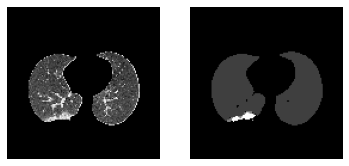

(32, 128, 128, 3)


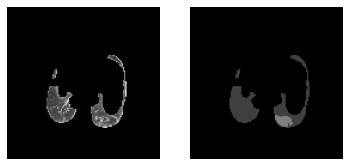

(32, 128, 128, 3)


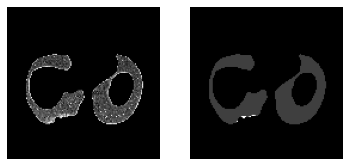

(32, 128, 128, 3)


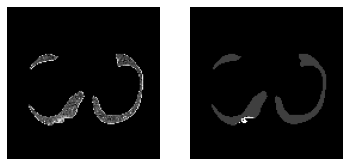

(32, 128, 128, 3)


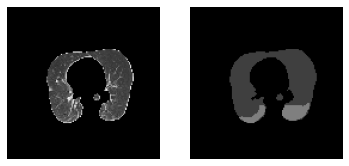

In [7]:
for _ in range(5):
    img = image_generator.next()
    mask = mask_generator.next()
    
    print(img.shape)
    plt.figure(1)
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    plt.imshow(mask[0])
    plt.axis('off')
    plt.show()


In [8]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = tf.concat([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=2, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5,name='BOTTLENECK')(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=1, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('sigmoid')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [9]:
# filters=32
nclasses=4

model = Unet(image_size//scale_factor, image_size//scale_factor, nclasses, filters)

model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [10]:
# learning rate schedule

def step_decay(epoch):
	initial_lrate = 1e-3
	drop = 0.1
	epochs_drop = 50
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [11]:
lr = LearningRateScheduler(step_decay)
es = EarlyStopping(patience=20,mode='min', verbose=1)
checkpoint_path ='/content/drive/My Drive/LungCT/' + experiment_name +'.h5'

mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1 , save_best_only=True, mode='min')

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=steps,
                    validation_data=val_generator,
                    validation_steps=steps_val,
                    epochs=200,
                    verbose=1,
                    callbacks=[es,mc,lr])

Epoch 1/200
24/24 [==============================] - 618s 26s/step - loss: 0.6945 - accuracy: 0.8062 - val_loss: 54.7381 - val_accuracy: 0.2427

Epoch 00001: val_loss improved from inf to 54.73815, saving model to /content/drive/My Drive/LungCT/ExpLungInf1_cropped2.h5
Epoch 2/200
24/24 [==============================] - 5s 232ms/step - loss: 0.6566 - accuracy: 0.8557 - val_loss: 46.6237 - val_accuracy: 0.0460

Epoch 00002: val_loss improved from 54.73815 to 46.62371, saving model to /content/drive/My Drive/LungCT/ExpLungInf1_cropped2.h5
Epoch 3/200
24/24 [==============================] - 5s 233ms/step - loss: 0.6454 - accuracy: 0.8637 - val_loss: 1.4815 - val_accuracy: 0.3582

Epoch 00003: val_loss improved from 46.62371 to 1.48147, saving model to /content/drive/My Drive/LungCT/ExpLungInf1_cropped2.h5
Epoch 4/200
24/24 [==============================] - 5s 230ms/step - loss: 0.6329 - accuracy: 0.8637 - val_loss: 0.7052 - val_accuracy: 0.7566

Epoch 00004: val_loss improved from 1.481

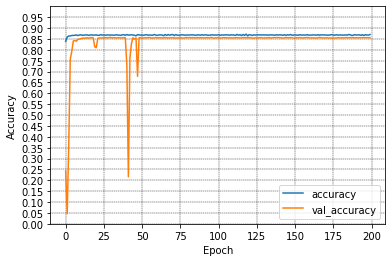

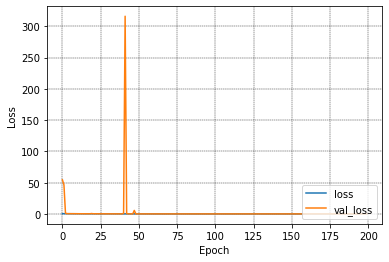

In [14]:
import numpy as np

plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(color='k', linestyle='--', linewidth=0.4)
plt.legend(loc='lower right')
#plt.savefig(dir + 'accuracy_CNN_ ' + Exp +  '.png')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
#plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(color='k', linestyle='--', linewidth=0.4)
plt.legend(loc='lower right')
#plt.savefig(dir + 'loss_CNN_' + Exp + '.png')

***Evaluation***
---



In [ ]:
import math
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm # Progress bar

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

model = keras.models.load_model('/content/drive/My Drive/LungCT/'+experiment_name+'.h5')

path = '/content/drive/My Drive/LungCT/Test/CT/CT_png/'
test_path = '/content/drive/My Drive/LungCT/Test/Mask_M/Mask_png/'

listfiles = sorted(os.listdir(path))
mask_listfiles = sorted(os.listdir(test_path))

dicescore = []
accuracy = []
sensitivity = []
specificity = []
f1score = []

IoUmetric = []

## Input image to model must be 128x128 therefore 512/4
scale = 2

In [ ]:
#for i in tqdm(range(len(listfiles))):
#for i in tqdm(range(100)):
for i in range(len(listfiles)):

  # List of files
  mask_im_name = mask_listfiles[i]
  im_name = listfiles[i]
       
# Groundtruth image (array)
  mask_array=cv2.imread(test_path+mask_im_name)   # Mask image
  im_array = cv2.imread(path+im_name)               # Graylevel image
  type(im_array)
  #im_gray = im_array.copy()
  im_gray = im_array
  
  #mask_array.shape()
  # Groundtruth mask Image resize
  mask_array=cv2.resize(mask_array,(512,512),interpolation = cv2.INTER_AREA)
  
  ## Input image to model must be 128x128 therefore 512/4
  scale = 4
  
  # Image resize must resize (Model input 128 x 128)
  im_array=cv2.resize(im_array,(512//scale_factor,512//scale_factor),
                      interpolation = cv2.INTER_AREA)
  im_array=im_array/255
  
  # Adding one dimension to array
  img_array = np.expand_dims(im_array,axis=[0])
  
  # Generate image prediction
  pred_mask = model.predict(img_array)
  
  # Image mask as (NxMx1) array
  pred_mask = pred_mask[0,:,:,0]
  pred_mask = np.uint16(np.round(pred_mask>0.5))
  
  # Resize image to 512x512x1
  pred_mask = cv2.resize(pred_mask,(512,512), 
                      interpolation = cv2.INTER_AREA)
  
  true_mask = np.uint16(mask_array[:,:,0])//255
  
  intersectmask = true_mask & pred_mask
  
  #sumintersectmask = np.sum(intersectmask)
  
  sumpredtrue = np.sum(true_mask)+np.sum(pred_mask)
  
  if sumpredtrue != 0:
        
      dice = 2*np.sum(intersectmask)/(np.sum(true_mask)+np.sum(pred_mask)+0.001)
  
      dicescore.append(dice)
  
  true_mask_flat = true_mask.flatten()
  pred_mask_flat = pred_mask.flatten()
  
  p = np.sum(true_mask_flat)
  n = np.sum(np.logical_not(true_mask_flat))
  tp = np.sum(true_mask_flat & pred_mask_flat)
  fp = np.sum(np.logical_not(true_mask_flat) & pred_mask_flat)
  tn = np.sum(np.logical_not(true_mask_flat) & np.logical_not(pred_mask_flat))
  fn = np.sum(true_mask_flat & np.logical_not(pred_mask_flat))
  
  acc = (tp+tn)/(p+n)
  sens = tp/(tp+fn+0.01) # Cuidado BUG!
  spec = tn/(tn+fp)

  IoU = tp/(tp+fp+fn+0.01)

  #f1 = 2*tp/(2*tp+fp+fn)
  
  IoUmetric.append(IoU)
  accuracy.append(acc)
  sensitivity.append(sens)
  specificity.append(spec)
    #f1score.append(f1)

In [ ]:
# Metrics

dicescore = np.array(dicescore)
meandice = np.mean(dicescore)
stddice = np.std(dicescore)

accuracy = np.array(accuracy)
meanacc = np.mean(accuracy)
stdacc = np.std(accuracy)

IoU = np.array(IoUmetric)
meanIoU = np.mean(IoUmetric)
stdIoU = np.std(IoUmetric)

# f1sco = np.array(f1score)
# meanf1 = np.mean(f1sco)
# stdf1 = np.std(f1sco)

print('------------------------')    
print('Mean Dice: '+str(meandice))
print('Std Dice: '+str(stddice))
print('------------------------')
print('Mean Acc: '+str(meanacc))
print('Std Acc: '+str(stdacc))
print('------------------------')
print('------------------------')
print('Mean IoU: '+str(meanIoU))
print('Std IoU: '+str(stdIoU))
print('------------------------')

------------------------
Mean Dice: 0.4419015666776796
Std Dice: 0.268145167267568
------------------------
Mean Acc: 0.9509874649913423
Std Acc: 0.04640387541246903
------------------------
------------------------
Mean IoU: 0.24964594335162799
Std IoU: 0.2410190191793543
------------------------
